In [ ]:
import numpy as np
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D
from sklearn.model_selection import train_test_split

In [2]:
#load cleaned data
loaded = np.load('mtg_data_balanced.npz', allow_pickle=True)
X = loaded['X']
y = loaded['Y']

In [3]:
#confirm correct loading and dimensions
print(f'Feature matrix shape: {X.shape}')
print(f'Label array shape: {y.shape}')

Feature matrix shape: (14500, 96, 1400, 1)
Label array shape: (14500, 11)


In [4]:
y= y.astype(np.float16)
X = X.astype(np.float16)

C:\Users\olive\AppData\Local\Temp\ipykernel_13348\60916125.py:1: RuntimeWarning: overflow encountered in cast
  y= y.astype(np.float16)


In [5]:
#splotting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training feature matrix shape: {X_train.shape}')
print(f'Testing feature matrix shape: {X_test.shape}')
print(f'Training label array shape: {y_train.shape}')
print(f'Testing label array shape: {y_test.shape}')

Training feature matrix shape: (11600, 96, 1400, 1)
Testing feature matrix shape: (2900, 96, 1400, 1)
Training label array shape: (11600, 11)
Testing label array shape: (2900, 11)


In [ ]:
#initial model
model = Sequential([
    Conv2D(filters=20, kernel_size=(5,5), strides=(2, 2), input_shape=[96,1400,1], padding='valid', activation='relu'),
    Conv2D(filters=40, kernel_size=(5,5), strides=(2, 2), input_shape=[96,1400,1], padding='valid', activation='relu'),
    Flatten(),
    Dense(10, activation='softmax'),
])
#model.compile(optimizer='adam', loss=', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train[:, 1:], epochs=4, batch_size=32, validation_data=(X_test, y_test[:, 1:]))

Epoch 1/4
 67/363 ━━━━━━━━━━━━━━━━━━━━ 13:50 3s/step - accuracy: 0.0921 - loss: 31.7886

note: this model was not re-run, as data was processed differently for future models. In the initial run of this model, training accuracy was around 90 percent and test accuracy around 30 percent, showing severe overfitting. This model was only memorizing the data, but kept for reference

In [14]:
y_test_pred = model.predict(X_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step


In [15]:
test_predicted = np.argmax(y_test_pred, axis=1)
test_true = np.argmax(y_test[:, 1:], axis=1)

In [34]:
genres = ['ambient_chill',
          'classical_orchestral',
          'electronic_edm',
          'folk_country',
          'funk_soul_rnb',
          'hiphop_rap',
          'jazz_fusion',
          'metal',
          'pop',
          'rock_punk']

Text(0.5, 1.0, 'Confusion Matrix for Music Genre Classification')

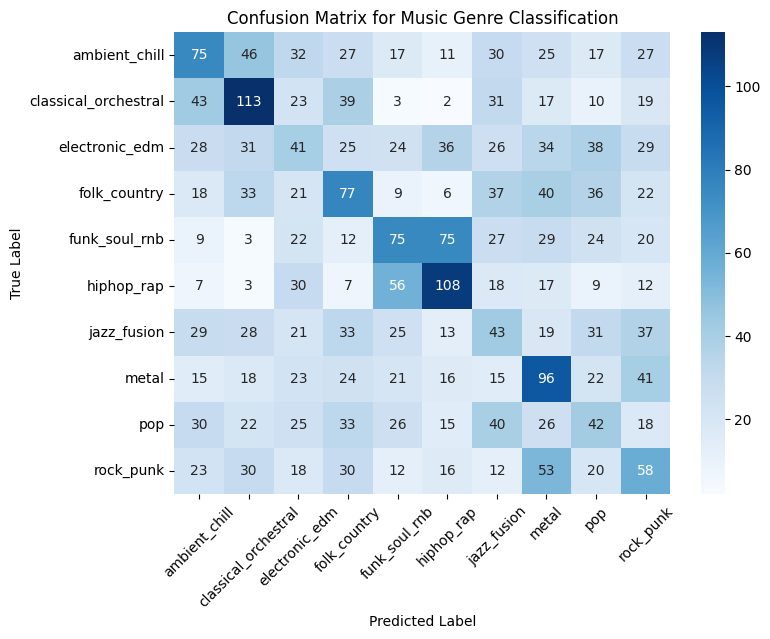

In [35]:
cm = confusion_matrix(test_true, test_predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')   
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=45)
plt.yticks(ticks=np.arange(len(genres))+0.5, labels=genres, rotation=0)
plt.title('Confusion Matrix for Music Genre Classification')


Even though the overall test accuracy is poor, we can see that it's easier for our model to identify certain genres. Orchestra and metal in particular. The matrix also confuses hiphop and funk, which makes sense given their similarities from the human perspective.

Lessons learned from initial model training and concerns going forward:

The model is severely over fit, and I will need to look into regularization methods. I didn't expect this, because I anticipated the chorus of songs to show up in both sets, resulting in high validation accuracy. That's doesn't seem to be the case. I'm want to try dropout layers and l2 norm regularization. Additionally, this architecture was an arbitrary choice so I want to be more intentional about architecture going forward.

Additionally, I might consider changing the way I sub-sampled the data. It might be just memorizing specific songs, because I did the sub sampling in order. This means that some songs didn't even get a clip featured while other songs had several clips represented in training. Additionally, I might consider adding randomness to the splitting process choruses or pieces of certain songs don't cluster in training or testing sets

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 698, 20)    │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 347, 40)    │        20,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 291480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     2,914,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,806,112 (33.59 MB)

 Trainable params: 2,935,370 (11.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,870,742 (22.40 MB)